## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [3]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'

fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

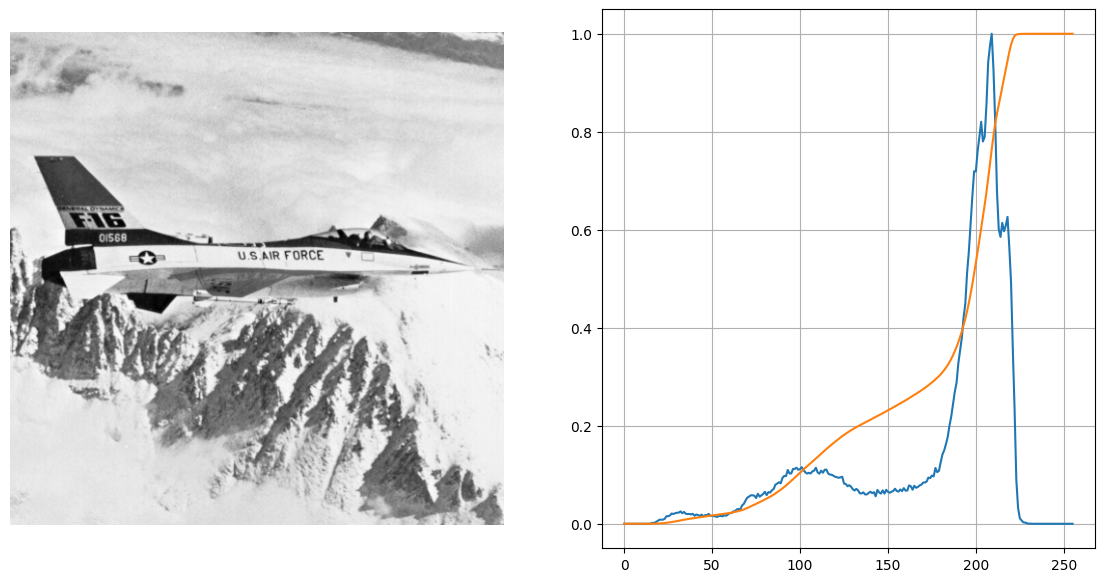

In [26]:
jet = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)

jet_hist = cv2.calcHist([jet], [0], None, [256], [0,256])

jet_cumhist = jet_hist.cumsum()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].axis('off')
axs[0].imshow(jet, 'gray')
axs[1].grid()
axs[1].plot(jet_hist / np.max(jet_hist))
axs[1].plot(jet_cumhist / np.max(jet_cumhist))

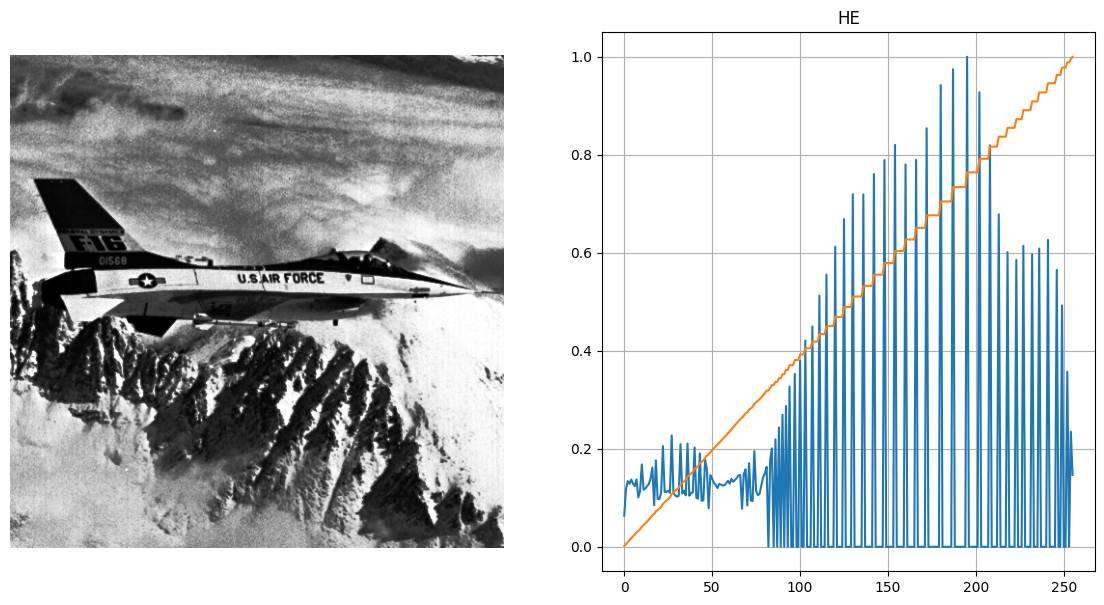

In [41]:
jet_he = cv2.equalizeHist(jet)

jet_he_hist = cv2.calcHist([jet_he], [0], None, [256], [0,256])

jet_he_cumhist = jet_he_hist.cumsum()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].axis('off')
axs[0].imshow(jet_he, 'gray')
axs[1].set_title("HE")
axs[1].grid()
axs[1].plot(jet_he_hist / np.max(jet_he_hist))
axs[1].plot(jet_he_cumhist / np.max(jet_he_cumhist))

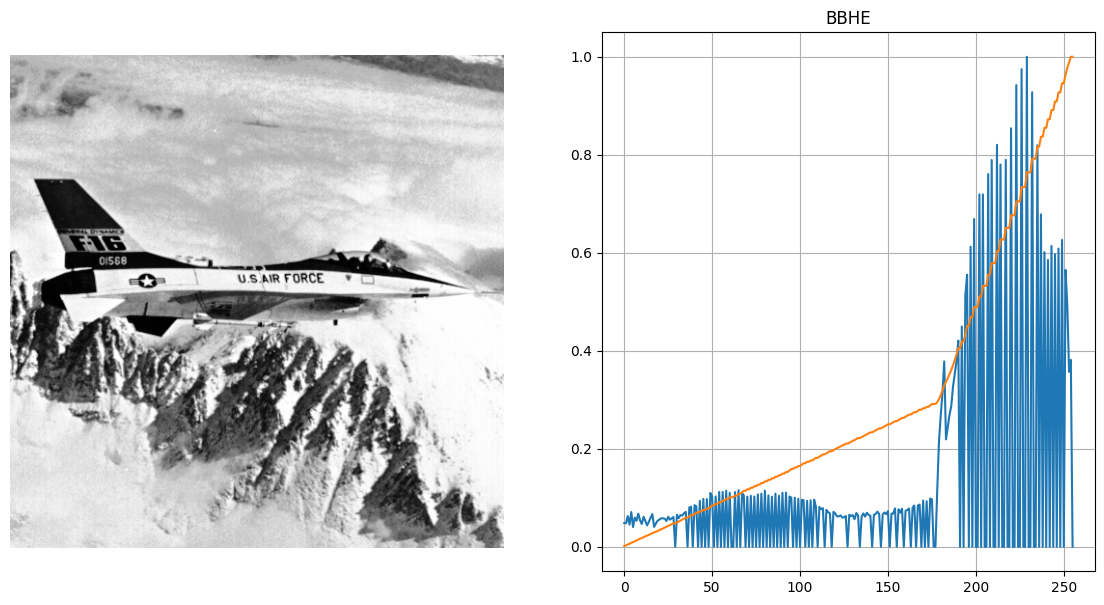

In [28]:
avg_brightness = int(np.mean(jet))

bbhe_H1 = jet_hist[:avg_brightness]
bbhe_H2 = jet_hist[avg_brightness:]

bbhe_C1 = bbhe_H1.cumsum()
bbhe_C2 = bbhe_H2.cumsum()

bbhe_C1 = bbhe_C1 / np.max(bbhe_C1)
bbhe_C2 = bbhe_C2 / np.max(bbhe_C2)

bbhe_C1n = np.uint8(avg_brightness * bbhe_C1)
bbhe_C2n = np.uint8(avg_brightness + 1 + (255 - avg_brightness - 1) * bbhe_C2)

bbhe_lut = np.concatenate((bbhe_C1n, bbhe_C2n))

jet_bbhe = cv2.LUT(jet, bbhe_lut)

jet_bbhe_hist = cv2.calcHist([jet_bbhe], [0], None, [256], [0,256])

jet_bbhe_cumhist = jet_bbhe_hist.cumsum()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].axis('off')
axs[0].imshow(jet_bbhe, 'gray')
axs[1].grid()
axs[1].set_title("BBHE")
axs[1].plot(jet_bbhe_hist / np.max(jet_bbhe_hist))
axs[1].plot(jet_bbhe_cumhist / np.max(jet_bbhe_cumhist))

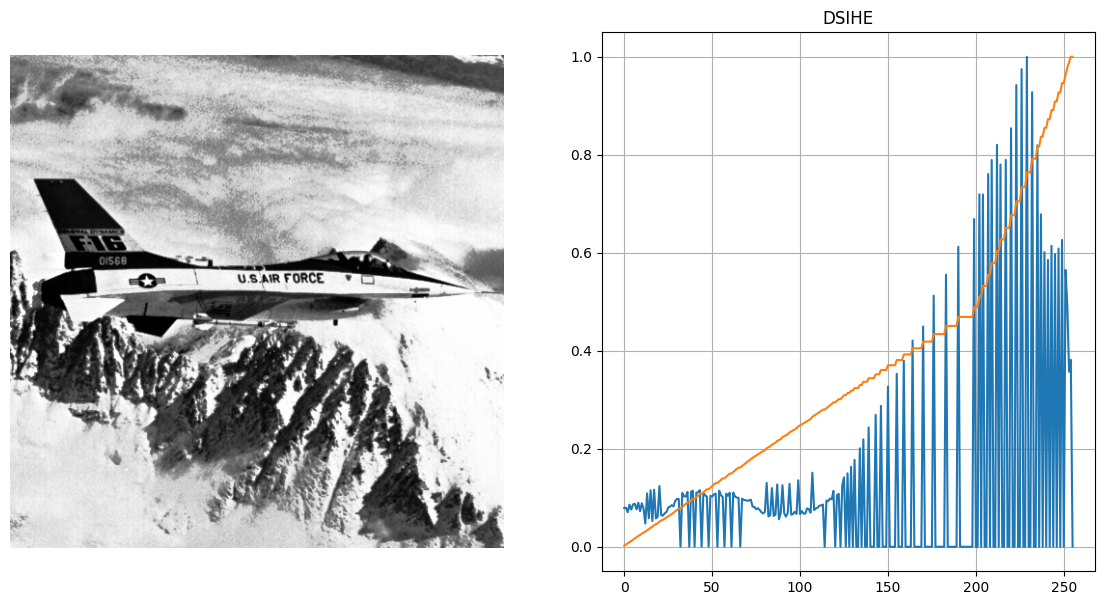

In [32]:
lm = np.argmin(np.abs(jet_cumhist - jet.size / 2))

dsihe_H1 = jet_hist[:lm]
dsihe_H2 = jet_hist[lm:]

dsihe_C1 = dsihe_H1.cumsum()
dsihe_C2 = dsihe_H2.cumsum()

dsihe_C1 = dsihe_C1 / np.max(dsihe_C1)
dsihe_C2 = dsihe_C2 / np.max(dsihe_C2)

dsihe_C1n = np.uint8(lm * dsihe_C1)
dsihe_C2n = np.uint8(lm + 1 + (255 - lm - 1) * dsihe_C2)

dsihe_lut = np.concatenate((dsihe_C1n, dsihe_C2n))

jet_dsihe = cv2.LUT(jet, dsihe_lut)

jet_dsihe_hist = cv2.calcHist([jet_dsihe], [0], None, [256], [0,256])

jet_dsihe_cumhist = jet_dsihe_hist.cumsum()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,7)

axs[0].axis('off')
axs[0].imshow(jet_dsihe, 'gray')
axs[1].set_title("DSIHE")
axs[1].grid()
axs[1].plot(jet_dsihe_hist / np.max(jet_dsihe_hist))
axs[1].plot(jet_dsihe_cumhist / np.max(jet_dsihe_cumhist))